In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import nltk
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import re
import string
from collections import Counter
from pathlib import Path

warnings.filterwarnings('ignore')
np.random.seed(42)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10
})

nltk_resources = ['punkt', 'stopwords', 'wordnet', 'omw-1.4']
for resource in nltk_resources:
    try:
        nltk.data.find(f'tokenizers/{resource}')
    except LookupError:
        nltk.download(resource, quiet=True)

In [5]:
def to_lowercase(text):
    """Convierte texto a minúsculas."""
    return str(text).lower() if pd.notna(text) else ""

def remove_urls(text):
    """Elimina URLs del texto."""
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

def remove_mentions_hashtags(text):
    """Elimina menciones @ y hashtags #."""
    return re.sub(r'@\w+|#', '', text)

def remove_punctuation(text):
    """Elimina signos de puntuación."""
    return re.sub(r'[^a-zA-Z\s]', '', text)

def normalize_whitespace(text):
    """Normaliza espacios en blanco."""
    return ' '.join(text.split())

def get_english_stopwords():
    """Retorna stopwords en inglés."""
    return set(nltk.corpus.stopwords.words('english'))

def remove_stopwords(text, stopwords):
    """Elimina stopwords del texto."""
    words = text.split()
    return ' '.join([word for word in words if word not in stopwords])

def correct_spelling(text):
    """Corrige ortografía con TextBlob."""
    try:
        return str(TextBlob(text).correct())
    except:
        return text

def count_words(texts):
    """Cuenta frecuencia de palabras en lista de textos."""
    all_words = ' '.join(texts).split()
    return Counter(all_words)

def filter_by_min_frequency(word_counts, min_freq):
    """Filtra palabras por frecuencia mínima."""
    return {word: count for word, count in word_counts.items() if count >= min_freq}

def filter_by_max_frequency(word_counts, max_freq):
    """Filtra palabras por frecuencia máxima."""
    return {word: count for word, count in word_counts.items() if count <= max_freq}

def get_valid_words(word_counts, min_freq, max_freq):
    """Obtiene palabras válidas por rango de frecuencia."""
    return {
        word for word, count in word_counts.items()
        if min_freq <= count <= max_freq
    }

def filter_text_by_vocabulary(text, valid_words):
    """Filtra texto manteniendo solo palabras válidas."""
    words = [word for word in text.split() if word in valid_words]
    return ' '.join(words)

def tokenize_text(text):
    """Tokeniza texto individual."""
    return nltk.word_tokenize(text)

def stem_tokens(tokens):
    """Aplica stemming a lista de tokens."""
    stemmer = nltk.PorterStemmer()
    return [stemmer.stem(token) for token in tokens]

def lemmatize_tokens(tokens):
    """Aplica lemmatización a lista de tokens."""
    lemmatizer = nltk.WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

def tokens_to_text(tokens):
    """Convierte lista de tokens a texto."""
    return ' '.join(tokens)

def calculate_tf(text):
    """Calcula Term Frequency para un texto."""
    words = text.split()
    word_count = len(words)
    if word_count == 0:
        return {}
    
    tf_dict = {}
    for word in words:
        tf_dict[word] = tf_dict.get(word, 0) + 1
    
    for word in tf_dict:
        tf_dict[word] = tf_dict[word] / word_count
    
    return tf_dict

def calculate_idf(texts):
    """Calcula Inverse Document Frequency para colección de textos."""
    N = len(texts)
    idf_dict = {}
    all_words = set(word for text in texts for word in text.split())
    
    for word in all_words:
        containing_docs = sum(1 for text in texts if word in text.split())
        idf_dict[word] = np.log(N / containing_docs)
    
    return idf_dict

def calculate_tfidf(tf_dict, idf_dict):
    """Calcula TF-IDF dados diccionarios TF e IDF."""
    tfidf_dict = {}
    for word, tf_val in tf_dict.items():
        tfidf_dict[word] = tf_val * idf_dict.get(word, 0)
    return tfidf_dict

def get_sentiment_polarity(text):
    """Obtiene polaridad de sentimiento."""
    return TextBlob(text).sentiment.polarity

def get_sentiment_subjectivity(text):
    """Obtiene subjetividad de sentimiento."""
    return TextBlob(text).sentiment.subjectivity

def cosine_similarity_vectors(vec1, vec2):
    """Calcula similitud coseno entre dos vectores."""
    return cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0, 0]

def plot_bar_chart(x_values, y_values, title, xlabel, ylabel, rotation=45):
    """Crea gráfico de barras básico."""
    fig, ax = plt.subplots(figsize=(12, 8))
    bars = ax.bar(range(len(x_values)), y_values, color='skyblue', alpha=0.8)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xticks(range(len(x_values)))
    ax.set_xticklabels(x_values, rotation=rotation, ha='right')
    
    plt.tight_layout()
    plt.show()

def plot_log_log(x_values, y_values, title, xlabel, ylabel):
    """Crea gráfico log-log."""
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.loglog(x_values, y_values, 'ro-', alpha=0.7)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def save_to_csv(data, filename):
    """Guarda datos a archivo CSV."""
    filepath = Path(filename)
    if isinstance(data, pd.DataFrame):
        data.to_csv(filepath, index=False)
    else:
        pd.Series(data).to_csv(filepath)
    return filepath

In [6]:
train_path = "/Users/pamelabenavides/repos/FCD_UV_2025/twitter_disaster_nlp/data/train.csv"
test_path = "/Users/pamelabenavides/repos/FCD_UV_2025/twitter_disaster_nlp/data/test.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

df_train.head()

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
target_counts = df_train['target'].value_counts()
missing_counts = df_train.isnull().sum()

print(f"Dataset shape: {df_train.shape}")
print(f"Target distribution: {dict(target_counts)}")
print(f"Missing values: {dict(missing_counts[missing_counts > 0])}")

Dataset shape: (7613, 5)
Target distribution: {0: np.int64(4342), 1: np.int64(3271)}
Missing values: {'keyword': np.int64(61), 'location': np.int64(2533)}


In [12]:
disaster_tweets = df_train[df_train['target'] == 1]['text']
non_disaster_tweets = df_train[df_train['target'] == 0]['text']

print("\nDisaster tweet samples:")
for i, tweet in enumerate(disaster_tweets.head(3), 1):
    print(f"{i}. {tweet[:100]}...")

print("\nNon-disaster tweet samples:")
for i, tweet in enumerate(non_disaster_tweets.head(3), 1):
    print(f"{i}. {tweet[:100]}...")


Disaster tweet samples:
1. Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all...
2. Forest fire near La Ronge Sask. Canada...
3. All residents asked to 'shelter in place' are being notified by officers. No other evacuation or she...

Non-disaster tweet samples:
1. What's up man?...
2. I love fruits...
3. Summer is lovely...


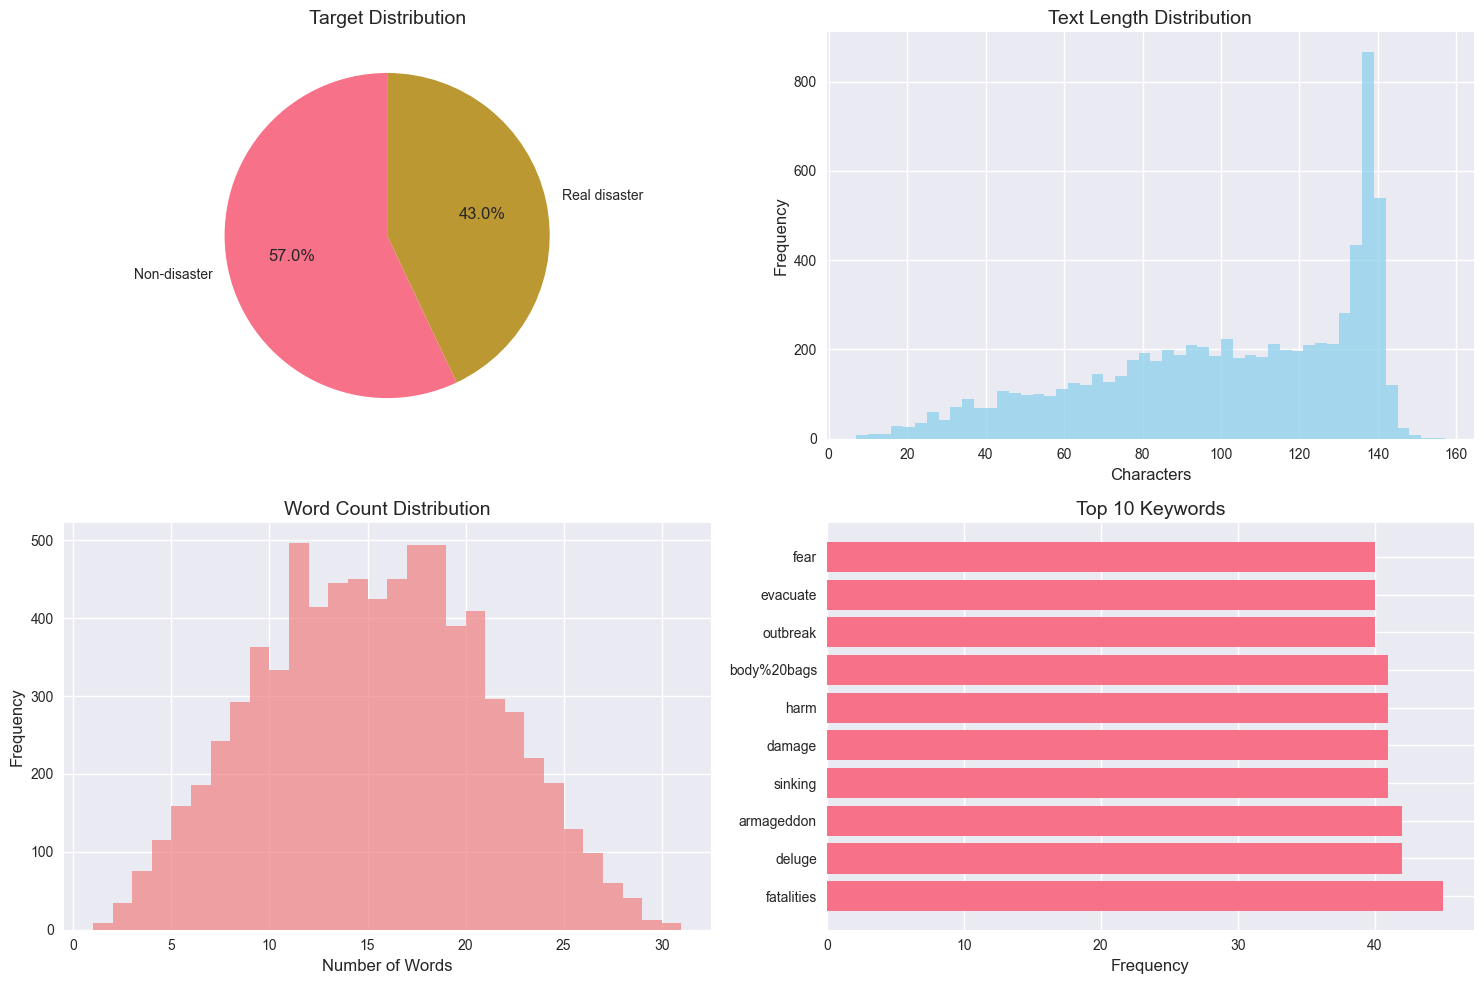

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].pie(target_counts.values, labels=['Non-disaster', 'Real disaster'], 
               autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Target Distribution')

text_lengths = df_train['text'].str.len()
axes[0, 1].hist(text_lengths, bins=50, alpha=0.7, color='skyblue')
axes[0, 1].set_title('Text Length Distribution')
axes[0, 1].set_xlabel('Characters')
axes[0, 1].set_ylabel('Frequency')

word_counts = df_train['text'].str.split().str.len()
axes[1, 0].hist(word_counts, bins=30, alpha=0.7, color='lightcoral')
axes[1, 0].set_title('Word Count Distribution')
axes[1, 0].set_xlabel('Number of Words')
axes[1, 0].set_ylabel('Frequency')

keyword_counts = df_train['keyword'].value_counts().head(10)
axes[1, 1].barh(range(len(keyword_counts)), keyword_counts.values)
axes[1, 1].set_yticks(range(len(keyword_counts)))
axes[1, 1].set_yticklabels(keyword_counts.index)
axes[1, 1].set_title('Top 10 Keywords')
axes[1, 1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()